In [ ]:
#Here are the sources to which all of this code is based on:
#https://blog.paperspace.com/introduction-to-seq2seq-models/
#https://medium.com/analytics-vidhya/seq2seq-abstractive-summarization-using-lstm-and-attention-mechanism-code-da2e9c439711

#NOTE: Here the following words describing the dataset/training/test data are equivalent


In [ ]:
!pip install tensorflow-gpu==1.15
# import keras==2.2.4
import numpy as np  
import pandas as pd 
import re           
import os
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
!pip install wget
import wget
import nltk


     |████████████████████████████████| 411.5 MB 6.6 kB/s 
     |████████████████████████████████| 3.8 MB 50.9 MB/s 
     |████████████████████████████████| 503 kB 65.5 MB/s 
     |████████████████████████████████| 50 kB 8.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=48d7f5a6866c44310a6578be9fcf4608153255fb0e152cb897192372c912f594
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Here we will read the datasets and combine them into 1 large one
#data2=pd.read_csv("/content/drive/My Drive/Reviews.csv", nrows=10000)
data = pd.read_csv("/content/drive/My Drive/LessHotels.csv")
data2 = pd.read_csv("/content/drive/My Drive/Hotels.csv")
data3 = pd.read_csv("/content/drive/My Drive/MoreHotels.csv")
data = pd.concat([data, data2], axis=0)
data = pd.concat([data, data3], axis=0)
data[['reviews.text','reviews.title']].sample(5)


,reviews.text,reviews.title
7089,xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx,NaN
2675,Awesome experience all around staff is friendly amenities are exemplary location is perfect during the week weekends may be a struggle to find dining but Uber or taxi will get you to all the aweso...,Perfect place for yourself or your family together
3821,Good: Location great and close to everything. Spacious and self-catering.,Good choice!
21887,"Room was Clean, quiet and comfortable. Nice stay. Only downside was Food for lunches during convention was less than average. I was surprised. On plated dinner there were about 6 quarter sized pot...",Nice for work
5470,I was not expecting a room with outside access. I would not have stayed there if I had know what to expect. The description listed the room as not ocean front. It should have stated it was in a se...,Hotel description was deceiving.


In [ ]:
#Remove columns that are irrelevant to our model
data = data.drop(['reviews.dateAdded', 'reviews.doRecommend', 'reviews.id', 'reviews.userCity', 'reviews.userProvince'  ], axis=1)

In [ ]:
data['reviews.text'][:10]

0         Pleasant 10 min walk along the sea front to the Water Bus. restaurants etc. Hotel was comfortable breakfast was good - quite a variety. Room aircon didn't work very well. Take mosquito repelant!
1    Really lovely hotel. Stayed on the very top floor and were surprised by a Jacuzzi bath we didn't know we were getting! Staff were friendly and helpful and the included breakfast was great! Great l...
2                                                                   Ett mycket bra hotell. Det som drog ner betyget var att vi fick ett rum under taksarna dr det endast var full sthjd i 80 av rummets yta.
3    We stayed here for four nights in October. The hotel staff were welcoming, friendly and helpful. Assisted in booking tickets for the opera. The rooms were clean and comfortable- good shower, light...
4    We stayed here for four nights in October. The hotel staff were welcoming, friendly and helpful. Assisted in booking tickets for the opera. The rooms were clean and comfortabl

In [ ]:
data.drop_duplicates(subset=['reviews.text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)

In [ ]:
#Dictionary linking words with similar meanings
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [ ]:
#Reset the index to make sure we can start with index 0 for simplicity
data = data.reset_index(drop=True)

In [ ]:
data['reviews.text']

0                                      Our experience at Rancho Valencia was absolutely perfect from beginning to end!!!! We felt special and very happy during our stayed. I would come back in a heart beat!!!
1        Amazing place. Everyone was extremely warm and welcoming. We've stayed at some top notch places and this is definitely in our top 2. Great for a romantic getaway or take the kids along as we did. ...
2        We booked a 3 night stay at Rancho Valencia to play some tennis, since it is one of the highest rated tennis resorts in America. This place is really over the top from a luxury standpoint and over...
3         Currently in bed writing this for the past hr 1/2 there have been dogs barking and squealing call the front desk to advise basically to be told there's nothing they can do. 315.00 and I can't sleep.
4        I live in Md and the Aloft is my Home away from home...we stayed 1 night 7-7-16 ...Staff is great ! Especially Olivia who was Extra special because she rem

In [ ]:
#This function will cleanup the text in the dataset, as well as removing short words in the reviews.
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()
#apply the function above
cleaned_text = []
for t in data['reviews.text']:
    cleaned_text.append(text_cleaner(t))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data['reviews.title'][:10]

0             Best romantic vacation ever!!!!
1                        Sweet sweet serenity
2             Amazing Property and Experience
3    Never again...beware, if you want sleep.
4                        ALWAYS GREAT STAY...
5                              Wonderful stay
6                             Worth the money
7                      Great Hotel Experiece!
8                    Short stay for business.
9            Amazing employees and facilities
Name: reviews.title, dtype: object

In [ ]:
#Same as above, but now apply to the review titles
def summary_cleaner(text):
    newString = re.sub('"','', str(text))
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['reviews.title']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)

data.dropna(axis=0,inplace=True)

In [ ]:
#Add start and end to indicate beginning and end of summary.
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')


In [ ]:
#Check to make sure everything works as intended
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: experience rancho valencia absolutely perfect beginning end felt special happy stayed would come back heart beat
Summary: _START_ best romantic vacation ever  _END_


Review: amazing place everyone extremely warm welcoming stayed top notch places definitely top great romantic getaway take kids along couple stuffed animals waiting girls upon arrival cannot wait back
Summary: _START_ sweet sweet serenity  _END_


Review: booked night stay rancho valencia play tennis since one highest rated tennis resorts america place really top luxury standpoint overall experience villas really perfect staff great attention details restaurants bar room service amazing tennis program really impressive well want come back
Summary: _START_ amazing property and experience  _END_


Review: currently bed writing past dogs barking squealing call front desk advise basically told nothing cannot sleep
Summary: _START_ never again beware if you want sleep  _END_


Review: live aloft home away home stayed n

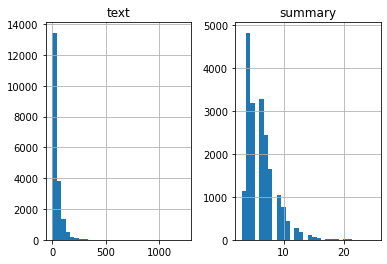

In [ ]:
#Get information regarding the length of the reviews and their respective titles
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Reviews':text_word_count, 'Titles':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
#Indicate max length of both the reviews and titles, so we don't run into RAM issues
max_len_text=150 
max_len_summary=20
from sklearn.model_selection import train_test_split
#Split our dataset into training and validation sets for X and Y.
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [ ]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [ ]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
from tensorflow.keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 500)     12213000    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 150, 500), ( 2002000     embedding[0][0]                  
_____________________________________________________________________________________________

In [ ]:
#Compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
# If desired we can add a parameter for early stopping during training
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
#Reshape to ensure we run into no dimensionality errors
x_tr
y_tr[:,:-1]
y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:]

array([[[  8],
        [  8],
        [  8],
        ...,
        [  0],
        [  0],
        [  0]],

       [[ 88],
        [ 59],
        [ 23],
        ...,
        [  0],
        [  0],
        [  0]],

       [[267],
        [  3],
        [ 91],
        ...,
        [  0],
        [  0],
        [  0]],

       ...,

       [[874],
        [ 28],
        [417],
        ...,
        [  0],
        [  0],
        [  0]],

       [[  3],
        [ 26],
        [ 60],
        ...,
        [  0],
        [  0],
        [  0]],

       [[ 79],
        [  1],
        [  0],
        ...,
        [  0],
        [  0],
        [  0]]], dtype=int32)

In [ ]:
#Run and train the model
#history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 17595 samples, validate on 1956 samples
Epoch 1/50
17595/17595 [==============================] - 73s 4ms/sample - loss: 2.1190 - val_loss: 1.3917
Epoch 2/50
17595/17595 [==============================] - 66s 4ms/sample - loss: 1.4334 - val_loss: 1.2979
Epoch 3/50
17595/17595 [==============================] - 66s 4ms/sample - loss: 1.3570 - val_loss: 1.2869
Epoch 4/50
17595/17595 [==============================] - 66s 4ms/sample - loss: 1.3051 - val_loss: 1.2252
Epoch 5/50
17595/17595 [==============================] - 66s 4ms/sample - loss: 1.2544 - val_loss: 1.1921
Epoch 6/50
17595/17595 [==============================] - 66s 4ms/sample - loss: 1.2098 - val_loss: 1.1730
Epoch 7/50
17595/17595 [==============================] - 66s 4ms/sample - loss: 1.1683 - val_loss: 1.1403
Epoch 8/50
17595/17595 [==============================] - 66s 4ms/sample - loss: 1.1282 - val_loss: 1.1250
E

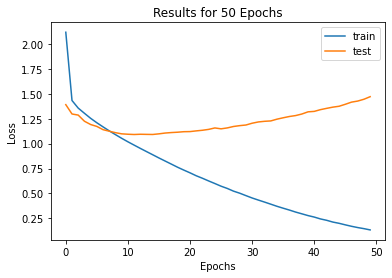

In [ ]:
#Get our results
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Results for 50 Epochs')
pyplot.legend() 
pyplot.show()

In [ ]:

reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
#Use the inference and the model to define a function to decode some sequence. This is where we will see how our model performs
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    print('input_seq: {}, e_out: {} '.format(input_seq,e_out))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        print(reverse_target_word_index)
        print(sampled_token_index)
        sampled_token = reverse_target_word_index[sampled_token_index]
        print("sampled_token:",sampled_token)
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (2*max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # stop_condition = True
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
#These two functions will give us the actual review or title of an input sequence
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
#Now to get the result
for i in range(10):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print(i)
  print("\n")

Review: ended hotel extremely unhappy went kind caring went way way knock price upgraded vip room morethank review glad see able make stay orlando pleasant one got rocky start hope see soon glad 
Original summary: amazing place 
input_seq: [[ 791    1  159 2371  115  153 1795  115  101  101 3146   58  571 3507
     2 1151   44  112   51  119   73    3  412  178   17   90 3638  518
    47   51  105  112    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
  #We can test this for any specific sequence
  print("Review:",seq2text(x_val[20]))
  print("Original summary:",seq2summary(y_val[20]))
  print("Predicted summary:",decode_sequence(x_val[20].reshape(1,max_len_text)))

Review: amazing best could stayed business san diego impress really stay lot great hotels like best western first jolla next mission valley sure staying different locations dear thank providing feedback recent stay best western seven seas san diego grateful kind remarks glad enjoyed value received thank choosing hotel accommodations look forward welcoming back next trip whether business pleasure sincerely best western seven seas management staff 
Original summary: must stay for the price 
input_seq: [[ 156   35   33   15  113  106  203 2822   42    3  108    5   74   28
    35  212   60 1331   30  897 1109  125   57  351 1067  151   16  622
    88  175    3   35  212 1223 1540  106  203 1502  153 2217  112   40
   166  487   16  386    1  430   83  117  219   23   30   75 1344  113
   479  210   35  212 1223 1540  391    4    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  